In [0]:
# Title: Cows and chickens
# Author: Valdo Joao - valdojoao90@gmail.com
# Date: 24/06/2019

In [0]:
import numpy as np
import pandas as pd
import math as ma

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.layers import Conv2D
from keras.layers import MaxPool2D, AvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from itertools import islice
import matplotlib.pyplot as plt

import time
import cpuinfo
import random

In [0]:
# original dataset
# data
#     -> chickens
#     -> cows

# This is how I have reorganized the data
# data
#     -> test - 20% of the dataset: 815 images
#            -> chickens
#            -> cows
#        
#     -> train - 60% of the dataset: 2403 images
#            -> chickens
#            -> cows
#       
#     -> validation - 20% of the dataset: 814 images
#            -> chickens
#            -> cows

In [0]:
#Design choices:
# 'relu' performs better on NN compared with others activation functions
# A classification problem to distinghih between 2 classes: 
# output_activation = 'sigmoid'; loss = 'binary_crossentropy'
# More than 2 classes we could use activation:softwax loss:categorical_crossentropy
# CNN works well with images, other options could be Random Forest, SVM, etc
# On CNN adaptive learning rate optimzers converge faster, 
# so both 'adam' or 'rmsprop' optimzers are good options

In [0]:
#Download dataset
!wget https://www.dropbox.com/s/oso328kp2rfu0x8/data_cainthus.tar.xz?dl=0 -O data_cainthus.tar.xz

#uncompress dataset
!tar xvf data_cainthus.tar.xz

#Dataset parameters
train_folder = 'data_cainthus/train'
test_folder = 'data_cainthus/test'
validation_folder = 'data_cainthus/validation'

#Network parameters 
input_size = 64       
output_size = 1
activation = 'relu'
output_activation = 'sigmoid'

#Trainning parameters
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

batchSize = 32
train_steps = ma.ceil(2403/batchSize)
valid_steps = ma.ceil(814/batchSize)
test_steps = ma.ceil(814/batchSize)
epochs = 150
verbose = 0

In [0]:
# data generator 
datagen = ImageDataGenerator(rescale = 1./255)

# perform some data augmentation on the training images
train_datagen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

def get_generator_from_dir(dataGenerator, folder):
    return dataGenerator.flow_from_directory(
    folder,
    target_size = (input_size, input_size),
    batch_size = batchSize,
    shuffle = True,
    class_mode = 'binary')

In [13]:
# generator for reading train data from folder
train_generator = get_generator_from_dir(train_datagen, train_folder)

Found 2403 images belonging to 2 classes.


In [14]:
# generator for reading validation data from folder
validation_generator = get_generator_from_dir(datagen, validation_folder)

Found 814 images belonging to 2 classes.


In [15]:
# generator for reading test data from folder
test_generator = get_generator_from_dir(datagen, test_folder)

Found 815 images belonging to 2 classes.


In [0]:
# neural network model
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (input_size, input_size, 3),
                 activation = activation))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation = activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation = activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

# we dont need a hidden layer on the NN as our data can be linearly separable
model.add(Dense(128,activation = activation))
model.add(Dense(output_size , activation = output_activation))

In [0]:
model.compile(loss = loss,
              optimizer = optimizer,
              metrics = metrics)

In [18]:
# get the summary of the Network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)         

In [0]:
#Using GPU could help to decrease a lot the overall computation time

In [20]:
start = time.time()

train_model = model.fit_generator(train_generator,
                    steps_per_epoch = train_steps,
                    epochs = epochs,
                    validation_data = validation_generator,
                    verbose = verbose,
                    validation_steps = valid_steps)

end = time.time()


Training_time = ma.ceil((end - start)/60)

print("Aprox training time in mins: " + str(Training_time))
print("CPU info:")
print("Brand: " + cpuinfo.get_cpu_info()['brand'])
print("Arch: " + cpuinfo.get_cpu_info()['arch'])
print("Hz actual: " + cpuinfo.get_cpu_info()['hz_actual'])
print("l3 cache size: " + cpuinfo.get_cpu_info()['l3_cache_size'])
print("l2 cache size: " + cpuinfo.get_cpu_info()['l2_cache_size'])
print("l1 data cache size: " + cpuinfo.get_cpu_info()['l1_data_cache_size'])
print("l1 instruction cache size: " + cpuinfo.get_cpu_info()['l1_instruction_cache_size'])

# Training the model on Google Colaboratory GPU took around 45mins, so its highly recommended
# Training the model on a local a computer with the bellow caracteristcs took around around 5h:30mins

Aprox training time in mins: 77
CPU info:
Brand: Intel(R) Xeon(R) CPU @ 2.20GHz
Arch: X86_64
Hz actual: 2.2000 GHz
l3 cache size: 56320 KB
l2 cache size: 256 KB
l1 data cache size: 32 KB
l1 instruction cache size: 32 KB


In [0]:
model.save('my_model' + '.h5')

In [0]:
# load_model('my_model' + '.h5')

In [23]:
# list all data in history
print(train_model.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Text(0.5, 1.0, 'History')

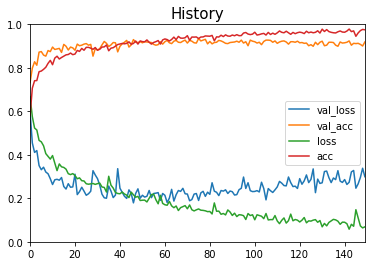

In [24]:
#plot the training history
historydf = pd.DataFrame(train_model.history, index=train_model.epoch)    
historydf.plot(ylim=(0,1))
plt.title("History", fontsize=15)

In [0]:
# prepare the data for the prediction
X_test = []
y_test = []

for ts in islice(test_generator, len(test_generator)):
    X_test.append(ts[0])
    y_test.append(ts[1])
    
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [0]:
#predict the model
y_pred = model.predict_classes(X_test).ravel()

In [27]:
#get the test accuraccy 
results = np.argwhere(y_test == y_pred).ravel()
test_acc = (len(results) / len(y_pred))
print("Accuraccy on the test set is: " + str(round(test_acc, 4)))

Accuraccy on the test set is: 0.9006


In [28]:
#show the evaluation metrics (precision, recall, f1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       396
         1.0       0.92      0.89      0.90       419

    accuracy                           0.90       815
   macro avg       0.90      0.90      0.90       815
weighted avg       0.90      0.90      0.90       815



In [0]:
#confusion_matrix
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    return df

In [30]:
pretty_confusion_matrix(y_test, y_pred, ['chicken', 'cow'])

,Predicted chicken,Predicted cow
chicken,363,33
cow,48,371


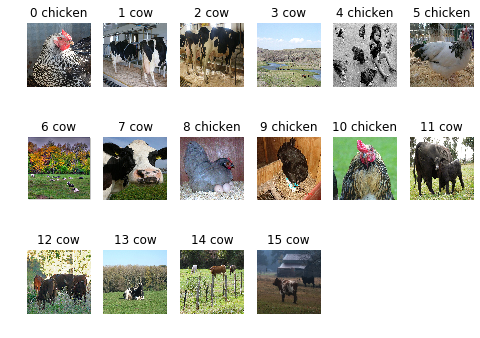

In [31]:
#Vizualization of the predicted result of the test data set
#classes: 0 chicken; 1 cow 

def animal(i):
    switcher={
                0:' chicken',
                1:' cow'
             }
    return switcher.get(i,"Invalid input")

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 6, i+1)
    plt.title(str(i) + animal(y_pred[i]))
    plt.axis('off')
    plt.imshow(X_test[i])